### This notebook will investigate the following question:
#### Q: Compare satellite vs GSM vs DME vs unknown contributions to RFI - relative importance


In [364]:
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
rcParams['figure.figsize'] = (11.7,8.27)
rcParams['font.size']=13
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
import time
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
from dask import compute
from dask import config

In [409]:
# Path to the DR0 and DR1 data-set
FileName1 = '/data/isaac/DR0/Single_obsDR0/DR0Full2.zarr/'
FileName2 = '/data/isaac/DR1/fullDR1.zarr'

In [410]:
# Loading the data
MyData1 = xr.open_zarr(FileName1)
MyData2 = xr.open_zarr(FileName2)

In [7]:
# Combining two dataset
data = MyData1+MyData2

In [411]:
# Extracting frequencies (MHz)
freq = data.frequency.values/1e6

In [412]:
# Extracting the Master and the Counter array
MyMaster = data.master.astype(float)
MyCounter =data.counter.astype(float)

In [319]:
#Computing Overall probability
MyMoverall = MyMaster.sum(dim = ['time','frequency','baseline','elevation','azimuth']) 
MyCoverall = MyCounter.sum(dim = ['time','frequency','baseline','elevation','azimuth'])
MyOverallProb = MyMoverall.astype(float)/MyCoverall.astype(float)
MyOverallProb  = MyOverallProb.persist()

## Plots of the overall Results

### Direction

In [13]:
# Azimuth
AzMaster = MyMaster.sum(dim = ['frequency','time','baseline','elevation']) 
AzCounter = MyCounter.sum(dim = ['frequency','time','baseline','elevation'])
AzProb = AzMaster.astype(float)/AzCounter.astype(float)
AzProb = AzProb.persist()

In [14]:
# Elevation and azimuth
FreqMaster = MyMaster.sum(dim = ['time','frequency','baseline']) 
FreqCounter = MyCounter.sum(dim = ['time','frequency','baseline'])
ElAzProb = FreqMaster.astype(float)/FreqCounter.astype(float)
ElAzProb = ElAzProb.persist()

/home/isihlangu/hprfi/local/lib/python3.5/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [15]:
# Elevation
ElMaster = MyMaster.sum(dim = ['frequency','time','baseline','azimuth']) 
ElCounter = MyCounter.sum(dim = ['frequency','time','baseline','azimuth'])
ElProb = ElMaster.astype(float)/ElCounter.astype(float)
ElProb = ElProb.persist()

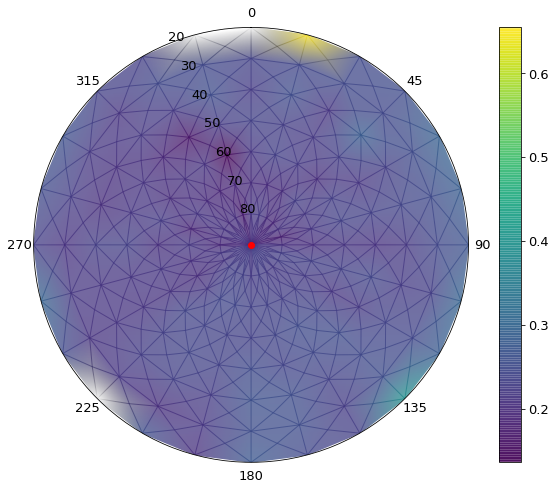

In [348]:
from scipy.interpolate import griddata
import matplotlib

# theta = np.deg2rad(AzProb.azimuth.values)
theta = np.deg2rad(np.arange(0,370,15))# + 7.5)
#r = 90.-ElProb.elevation.values
r = 80.-ElProb.elevation.values #- 5.0

#grid_r, grid_theta = np.meshgrid(r, theta)
#data = griddata(points, values, (grid_r, grid_theta))#, method='cubic')
Mydata = ElAzProb.values

# Adding the the last item to interpolate
MyNewData = np.concatenate((Mydata, Mydata[:,0,None]), axis=1)

#print("Data shape",MyNewData.shape)

#Create a polar projection
plt.figure(figsize=(11,8))

ax1 = plt.subplot(projection="polar")


#cmap = ax1.pcolormesh(-theta,r,data,alpha = 0.5)#, shading='gouraud')
cmap = ax1.pcolormesh(-theta,r,MyNewData,alpha = 0.75, shading='gouraud')#,norm=matplotlib.colors.PowerNorm(),cmap='PuOr')
ax1.set_yticklabels(np.arange(80,10,-10))

OwnLabel = [0,315,270,225,180,135,90,45]
ax1.set_xticklabels(OwnLabel)
ax1.set_theta_zero_location('N')
ax1.plot(0,0,'ro')
plt.colorbar(cmap)
#plt.colorbar('PuBu_r')
#ax1.set_rlim(10)
#ax1.set_rscale('log')

plt.show()

### Time and Frequency

In [17]:
MyMeanTimeMaster = MyMaster.sum(dim = ['frequency','baseline','elevation','azimuth']) 
MyMeanTimeCounter = MyCounter.sum(dim = ['frequency','baseline','elevation','azimuth'])
MyMeanTimeProb = MyMeanTimeMaster.astype(float)/MyMeanTimeCounter.astype(float)
MyMeanTimeProb = MyMeanTimeProb.persist()

In [18]:
MyMeanFreqMaster = MyMaster.sum(dim = ['time','baseline','elevation','azimuth']) 
MyMeanFreqCounter = MyCounter.sum(dim = ['time','baseline','elevation','azimuth'])
MyMeanFreqProb = MyMeanFreqMaster.astype(float)/MyMeanFreqCounter.astype(float)
MyMeanFreqProb = MyMeanFreqProb.persist()

In [34]:
TimeFreqMaster = MyMaster.sum(dim = ['azimuth','baseline','elevation']) 
TimeFreqCounter = MyCounter.sum(dim = ['azimuth','baseline','elevation'])
MyMeanTimeFreqProb = TimeFreqMaster.astype(float)/TimeFreqCounter.astype(float)
MyMeanTimeFreqProb = MyMeanTimeFreqProb.persist()

In [86]:
freq = MyMeanFreqProb.frequency.frequency.values/1e6

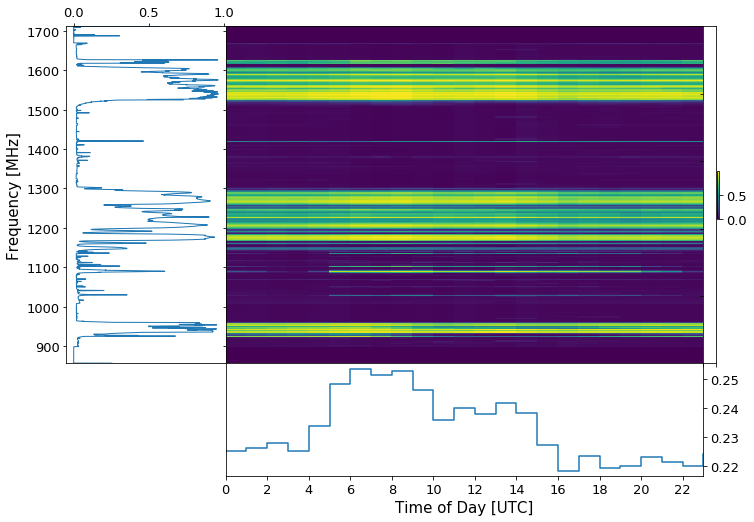

In [160]:
#plt.figure(figsize=(12,12))

gs = gridspec.GridSpec(2, 3, width_ratios=[1,3,0.1], height_ratios=[3,1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[4])

ax1.plot(MyMeanFreqProb.data, MyMeanFreqProb.frequency.frequency.values/1e6,lw=1.0)
ax1.xaxis.tick_top()
#ax1.set_ylim(MyMeanFreqProb.frequency.frequency.values[0],MyMeanFreqProb.frequency.frequency[-1])
ax1.set_ylim(freq[0],freq[-1])
ax1.set_ylabel('Frequency [MHz]', fontsize=15)

pc = ax2.pcolormesh( MyMeanTimeProb.time, MyMeanFreqProb.frequency, MyMeanTimeFreqProb.data.T,cmap='viridis')#, vmin=0.0)#, vmax=4.5)
ax2.set_xlim(MyMeanTimeProb.time.data[0], MyMeanTimeProb.time.data[-1])
ax2.set_ylim(MyMeanFreqProb.frequency.data[0], MyMeanFreqProb.frequency.data[-1])
ax2.set_xticklabels('')
ax2.set_yticklabels('')

plt.colorbar(pc,ax=ax3)
ax3.set_xticklabels('')
ax3.set_yticklabels('')

ax4.plot(MyMeanTimeProb.time.data, MyMeanTimeProb, '-')#where='post')
ax4.yaxis.tick_right()
ax4.set_xlim(0,23)
#ax3.set_xticks(4*np.arange(6), ["00H00", "04H00", "08H00", "12H00", "16H00", "20H00", "24H00"])
ax4.set_xticks(np.arange(0,23,step=2))
               
ax4.set_xlabel('Time of Day [UTC]', fontsize=15)

plt.subplots_adjust(wspace=0.0, hspace=0.0)
#plt.savefig(outputfile+'.png')
plt.show()


### Elevation and azimuth

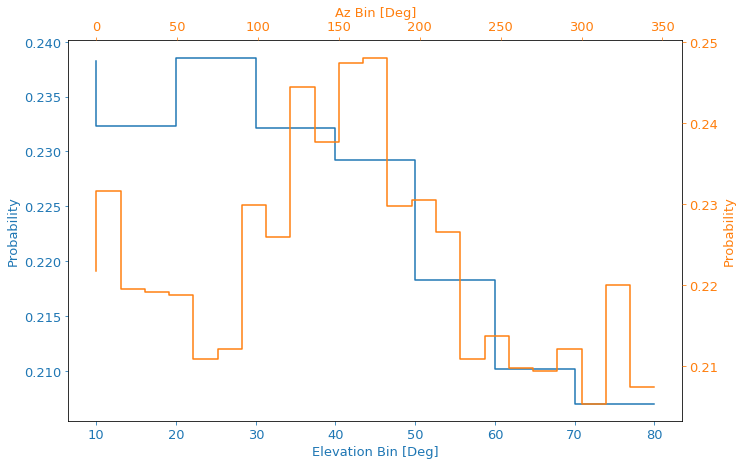

In [413]:
fig=plt.figure(figsize = (11,7))

ax=fig.add_subplot(111, label="1")

ax.step(ElProb.elevation,ElProb.data)
ax.set_xlabel('Elevation Bin [Deg]', color="C0")
ax.set_ylabel('Probability', color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2=fig.add_subplot(111, label="2", frame_on=False)

ax2.step(AzProb.azimuth,AzProb.data,color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Az Bin [Deg]', color="C1") 
ax2.set_ylabel('Probability', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")
plt.show()

#### Ploting fucnction

In [414]:
def MyPLot(AzProb,ElProb,Mydata):
    
    print(Mydata.shape)
    theta = np.deg2rad(np.arange(0,370,15)) #+ 7.5)
    #r = 90.-ElProb.elevation.values
    r = 80.-ElProb.elevation.values# - 5.0
    #data = ElAzProb.values
    MyNewData = np.append(Mydata.values,Mydata.values[:,0][:,None],axis=1)
    #print(data.shape,r.shape, theta.shape)

    #Create a polar projection
    plt.figure(figsize=(11,8))
    #plt.gca().invert_yaxis()

    ax1 = plt.subplot(projection="polar")

    cmap = ax1.pcolormesh(-theta,r,MyNewData,vmin= 0.0,alpha = 0.75,shading='gouraud')
    ax1.set_yticklabels(np.arange(80,10,-10))

    OwnLabel = [0,315,270,225,180,135,90,45]
    ax1.set_xticklabels(OwnLabel)
    ax1.set_theta_zero_location('N')

    plt.colorbar(cmap)
    plt.show()
    return()

## GSM Anaysis

### Time Analysis

GSM-900 uplink 0.0005792085918244996
GSM-900 downlink 0.023104293842044193
GSM-1800 uplink 0.00014335703273566784


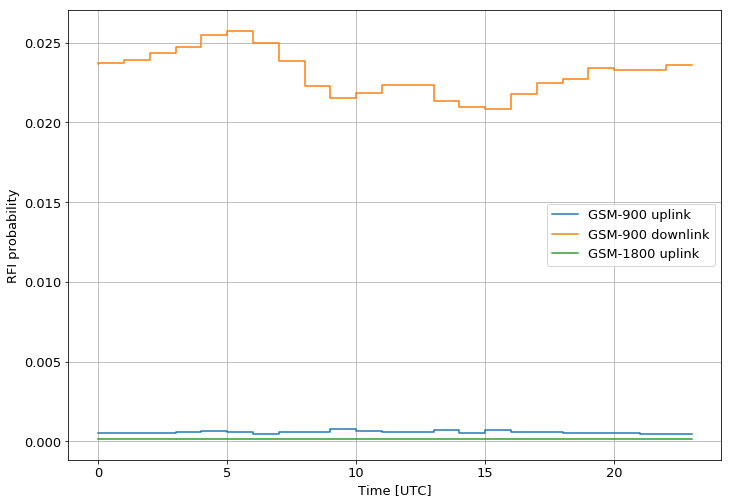

In [365]:
idx1 = np.where((freq>=890.) & (freq<=915.))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='GSM-900 uplink')
print('GSM-900 uplink',np.mean(p.values))

idx1 = np.where((freq>=935.) & (freq<=960))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='GSM-900 downlink')
print('GSM-900 downlink',np.mean(p.values))

idx1 = np.where((freq>=1710) & (freq<=1785))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='GSM-1800 uplink')
print('GSM-1800 uplink',np.mean(p.values))

plt.legend()
plt.xlabel('Time [UTC]')
plt.ylabel('RFI probability')
plt.grid()
plt.show()

GSM-900 uplink 0.0005792085918244996


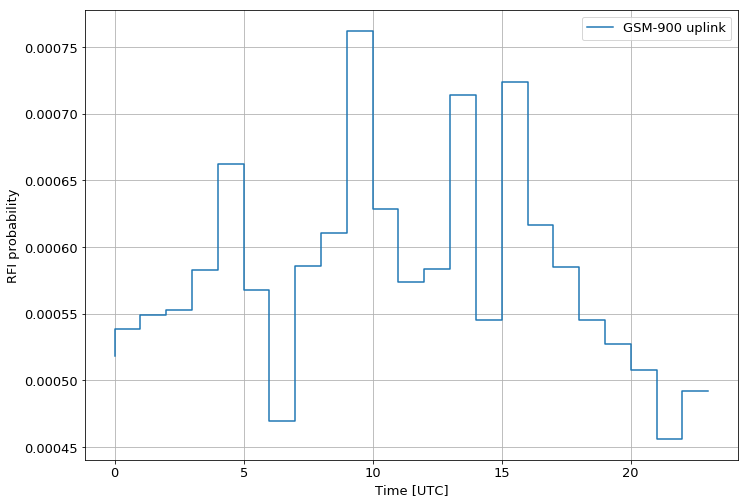

In [366]:
idx1 = np.where((freq>=890.) & (freq<=915.))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='GSM-900 uplink')
print('GSM-900 uplink',np.mean(p.values))
plt.legend()
plt.xlabel('Time [UTC]')
plt.ylabel('RFI probability')
plt.grid()
plt.show()

GSM-1800 uplink 0.00014335703273566784


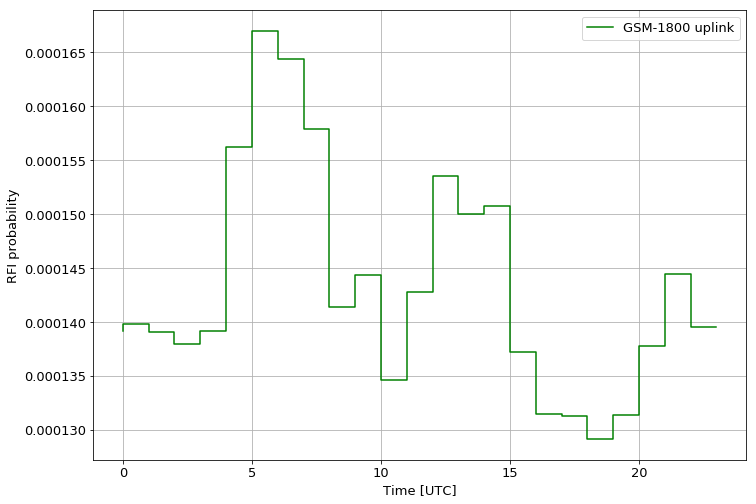

In [368]:
idx1 = np.where((freq>=1710.) & (freq<=1785))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='GSM-1800 uplink',color='g')
print('GSM-1800 uplink',np.mean(p.values))
plt.legend()
plt.xlabel('Time [UTC]')
plt.ylabel('RFI probability')
plt.grid()
plt.show()

### Direction Analysis

(8, 24)


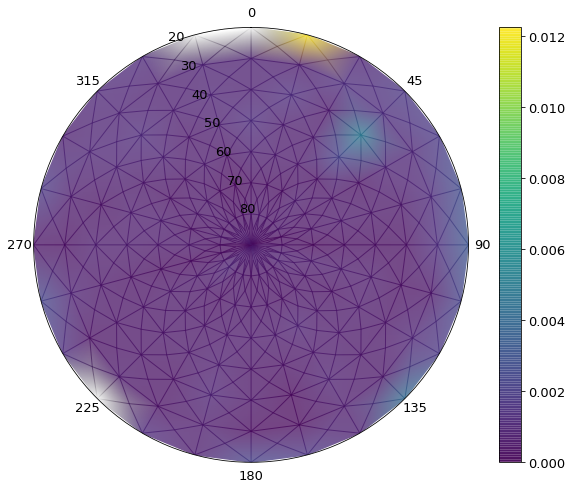

In [351]:
# GSM-900 Uplink uses 890 - 915 MHz
FreqLo = 890.
FreqHi = 915.
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")
    

(8, 24)


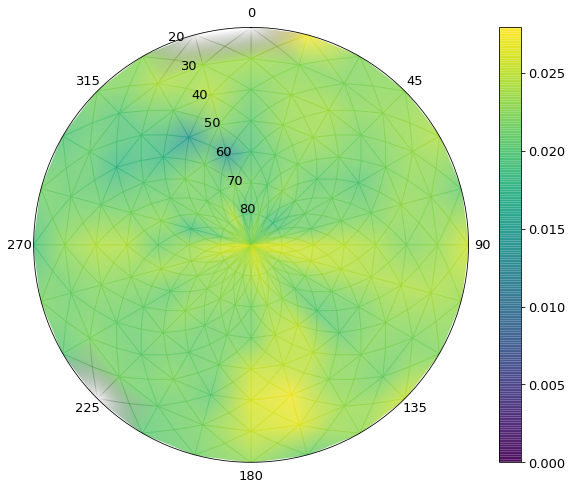

In [352]:
# GSM-900 Downlink uses 890 - 915 MHz
FreqLo = 935.
FreqHi = 960.
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

(8, 24)


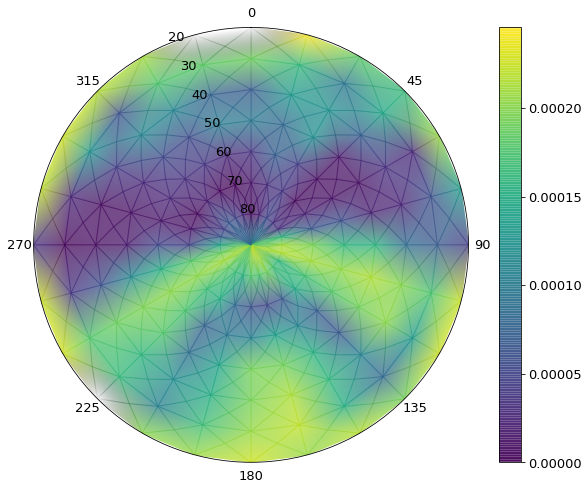

In [353]:
# GSM-1800 Uplink uses 1710 - 1785 MHz
FreqLo = 1710.
FreqHi = 1785.
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")


## DME selection 

### Dircetion

(8, 24)


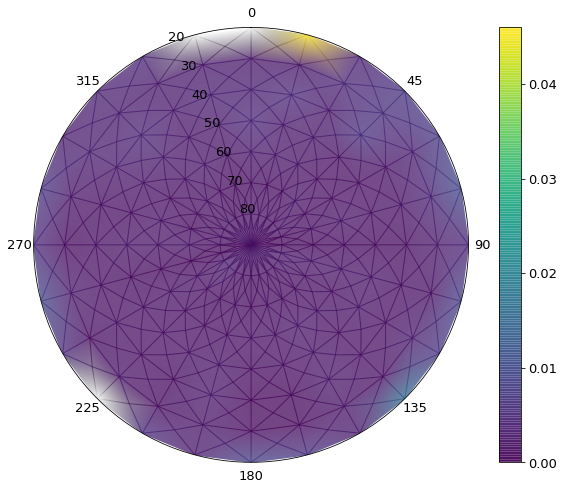

In [354]:
FreqLo = 962
FreqHi = 1024

ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")
    

(8, 24)


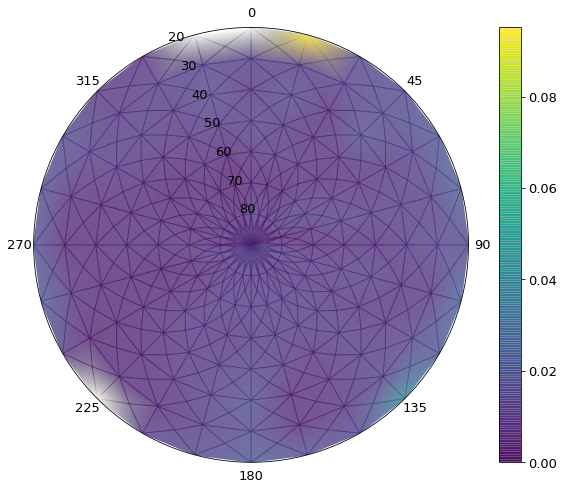

In [355]:
FreqLo =  1025
FreqHi = 1150

ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")
    
    

/home/isihlangu/hprfi/local/lib/python3.5/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


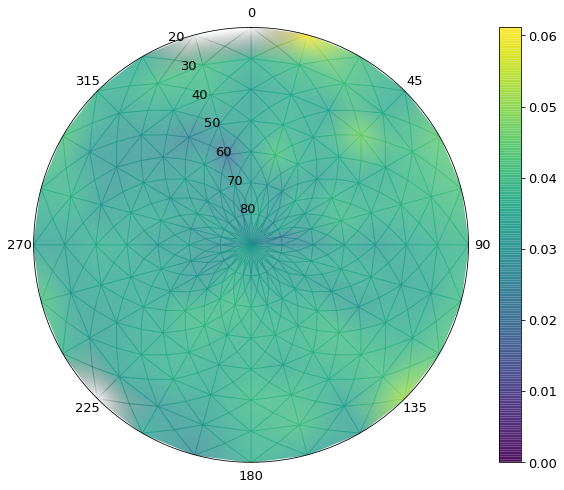

In [390]:
FreqLo = 1151
FreqHi = 1213

ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]
if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")
    

In [385]:
l5idx = np.where((freq>=1170.02)&(freq<=1182.72))[0]
a2gidx = np.where((freq>=1151.0)&(freq<=1213.))[0]
notl5 = []
for value in a2gidx:
    if value not in l5idx:
        notl5.append(value)

/home/isihlangu/hprfi/local/lib/python3.5/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


(8, 24)


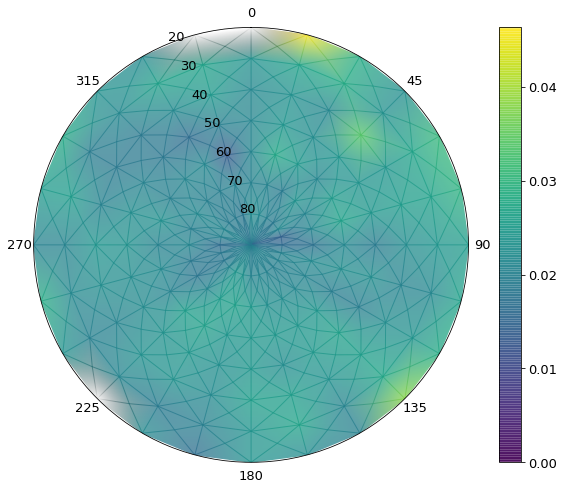

In [391]:
# Removing L5 from the DME air to ground
ChanIndx = notl5
if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

### Time 

G2A 1 0.0022721044315519414
A2G 0.017582960381402505
G2A 2 0.038911953984337215


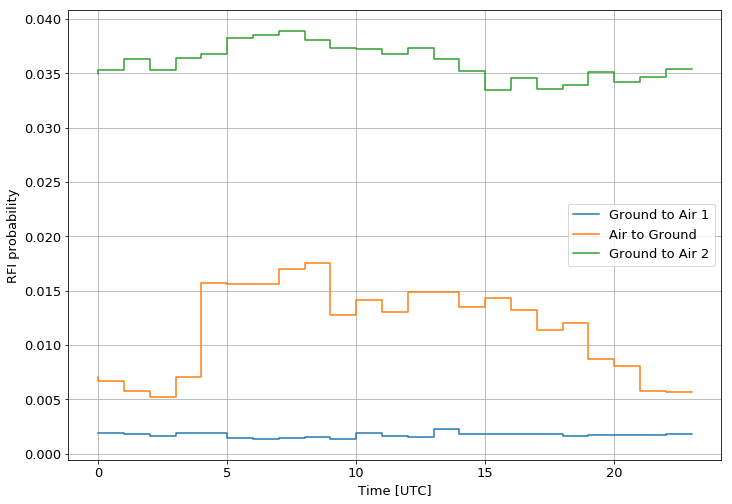

In [401]:
idx1 = np.where((freq>=962.) & (freq<=1024.))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='Ground to Air 1')
print('G2A 1',np.max(p.values))

idx1 = np.where((freq>=1025.) & (freq<=1150))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='Air to Ground')
print('A2G',np.max(p.values))

idx1 = np.where((freq>=1151) & (freq<=1213))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='Ground to Air 2')
print('G2A 2',np.max(p.values))

plt.legend()
plt.xlabel('Time [UTC]')
plt.ylabel('RFI probability')
plt.grid()
plt.show()

G2A 2 0.035987656089708615


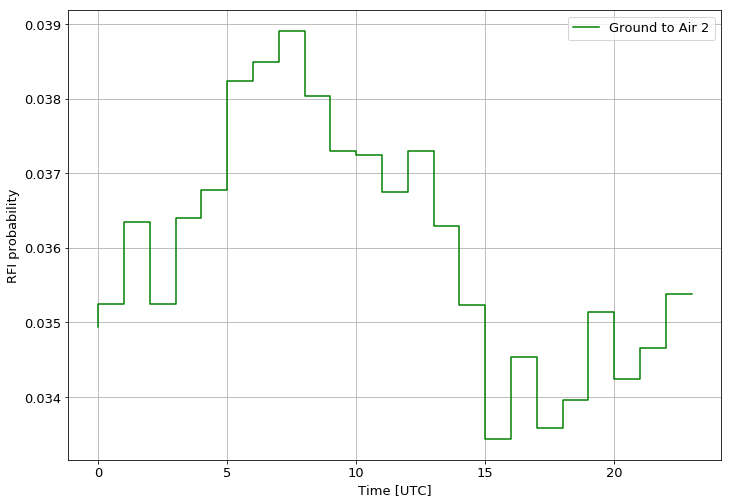

In [399]:
idx1 = np.where((freq>=1151) & (freq<=1213))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='Ground to Air 2',color='g')
print('G2A 2',np.mean(p.values))
plt.legend()
plt.xlabel('Time [UTC]')
plt.ylabel('RFI probability')
plt.grid()
plt.show()

G2A 2 0.022703777979004386


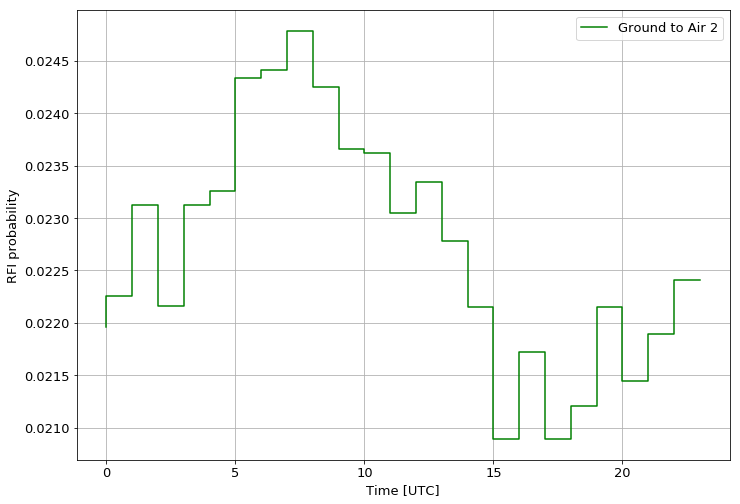

In [400]:
idx1 = notl5
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='Ground to Air 2',color='g')
print('G2A 2',np.mean(p.values))
plt.legend()
plt.xlabel('Time [UTC]')
plt.ylabel('RFI probability')
plt.grid()
plt.show()

G2A 1 0.001725094625197329


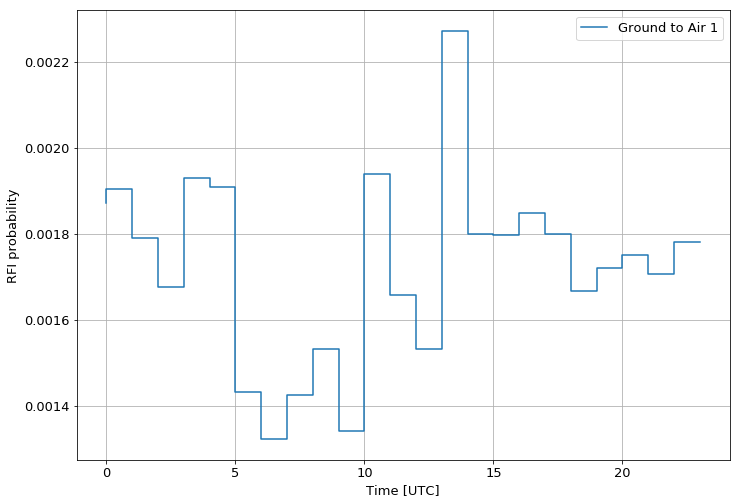

In [397]:
idx1 = np.where((freq>=962.) & (freq<=1024.))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='Ground to Air 1')
print('G2A 1',np.mean(p.values))
plt.legend()
plt.xlabel('Time [UTC]')
plt.ylabel('RFI probability')
plt.grid()
plt.show()

## GPS sattellite

In [357]:
# These are the central frequency
L1 = np.arange(1575.42-(15.345*0.5),1575.42+(15.345*0.5))
L2 = np.arange(1227.6-(11.*0.5),1227.6+(11.*0.5))
L3 = np.arange(1381.05-(10.23*0.5),1381.05+(10.23*0.5))
L4 = np.arange(1379.91-(10.23*0.5),1379.91+(10.23*0.5))
L5 = np.arange(1176.45-(12.5*0.5),1176.45+(12.5*0.5))

### Dircetion

(8, 24)


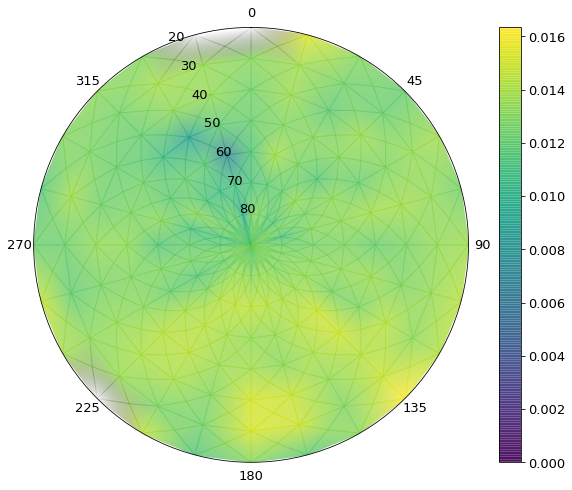

In [358]:
FreqLo = L1[0]
FreqHi = L1[-1]
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

(8, 24)


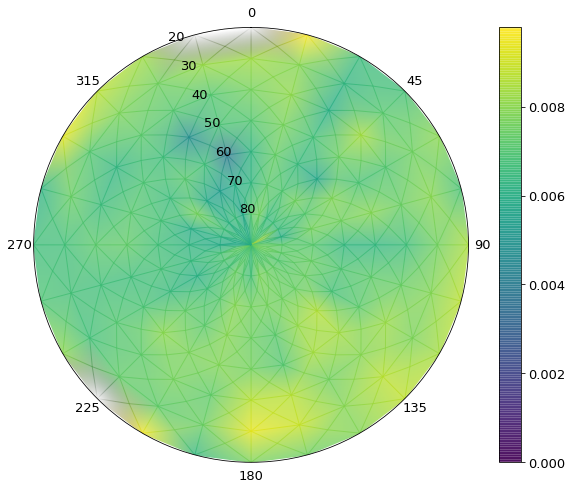

In [359]:
FreqLo = L2[0]
FreqHi = L2[-1]
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

(8, 24)


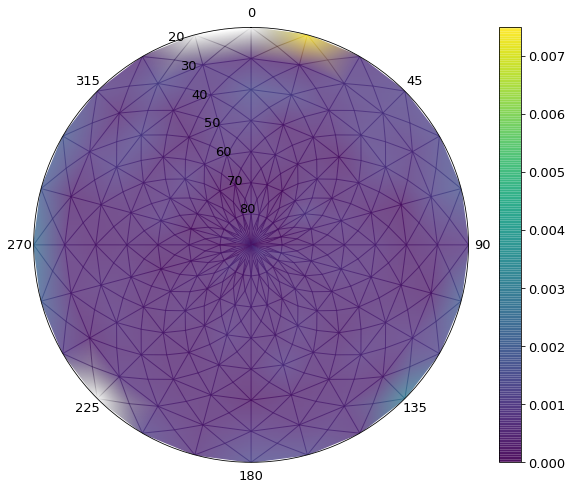

In [360]:
FreqLo = L3[0]
FreqHi = L3[-1]
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

(8, 24)


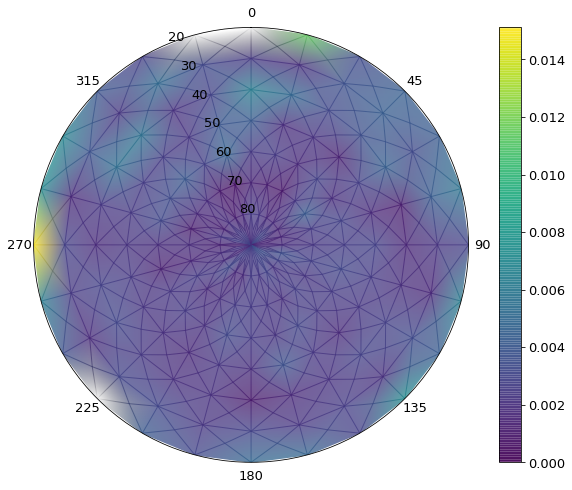

In [361]:
FreqLo = L4[0]
FreqHi = L4[-1]
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyMaster.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

(8, 24)


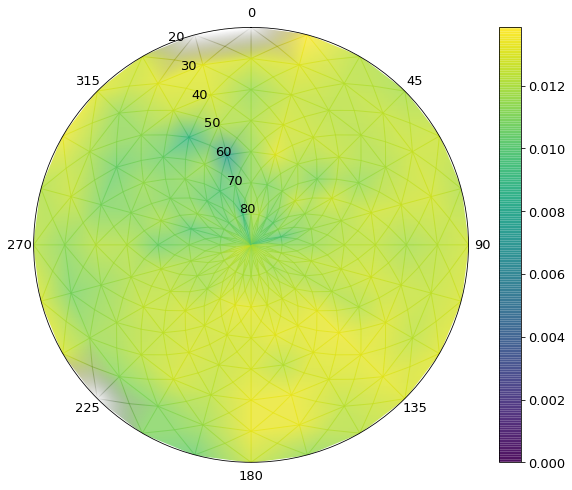

In [362]:
FreqLo = L5[0]
FreqHi = L5[-1]
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

(8, 24)


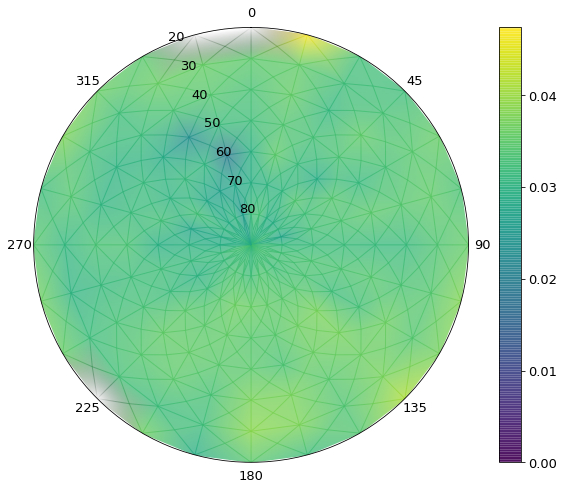

In [363]:
# Total of the GPS
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= L1[0]*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= L1[-1]*1.e6) |
                    
                    (MyMeanFreqProb.frequency.frequency >= L2[0]*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= L2[-1]*1.e6) |
                    
                    (MyMeanFreqProb.frequency.frequency >= L3[0]*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= L3[-1]*1.e6) |
                    (MyMeanFreqProb.frequency.frequency >= L4[0]*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= L4[-1]*1.e6) |
                    (MyMeanFreqProb.frequency.frequency >= L5[0]*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= L5[-1]*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")
    
    

L1 0.014484023468282096
L2 0.00818388824024126
L3 0.0007460378917018189
L4 0.0007448090834763863
L5 0.013251690410514176


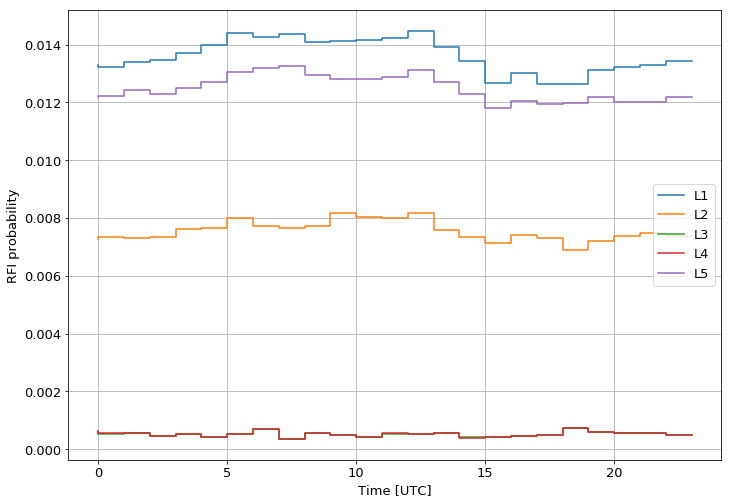

In [402]:
idx1 = np.where((freq>=L1[0]) & (freq<=L1[-1]))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='L1')
print('L1',np.max(p.values))

idx1 = np.where((freq>=L2[0]) & (freq<=L2[-1]))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='L2')
print('L2',np.max(p.values))

idx1 = np.where((freq>=L3[0]) & (freq<=L3[-1]))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='L3')
print('L3',np.max(p.values))


idx1 = np.where((freq>=L4[0]) & (freq<=L4[-1]))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='L4')
print('L4',np.max(p.values))


idx1 = np.where((freq>=L5[0]) & (freq<=L5[-1]))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='L5')
print('L5',np.max(p.values))
plt.legend()
plt.xlabel('Time [UTC]')
plt.ylabel('RFI probability')
plt.grid()
plt.show()

## Clean Band

(8, 24)


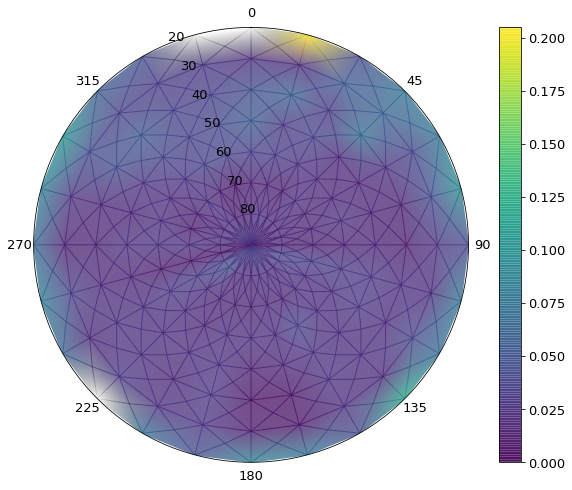

In [405]:
FreqLo = 1310
FreqHi = 1490
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyMaster.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")

Clean band 0.007264993325752913


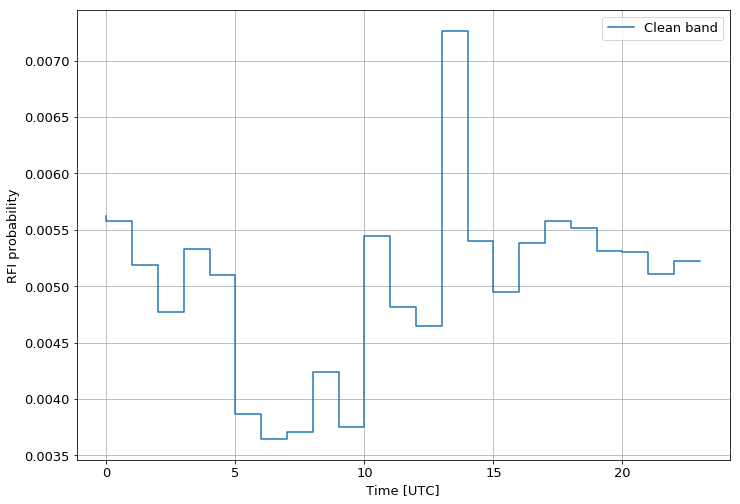

In [406]:

idx1 = np.where((freq>=1310) & (freq<=1490))[0]
tm = MyMaster[:,idx1].sum(dim=['frequency','baseline','azimuth','elevation'])
tc = MyCounter.sum(dim=['frequency','baseline','azimuth','elevation'])
p = tm.astype(float)/tc.astype(float)
plt.step(data.time.values,p,label='Clean band')
print('Clean band',np.max(p.values))
plt.legend()
plt.xlabel('Time [UTC]')
plt.ylabel('RFI probability')
plt.grid()
plt.show()

(8, 24)


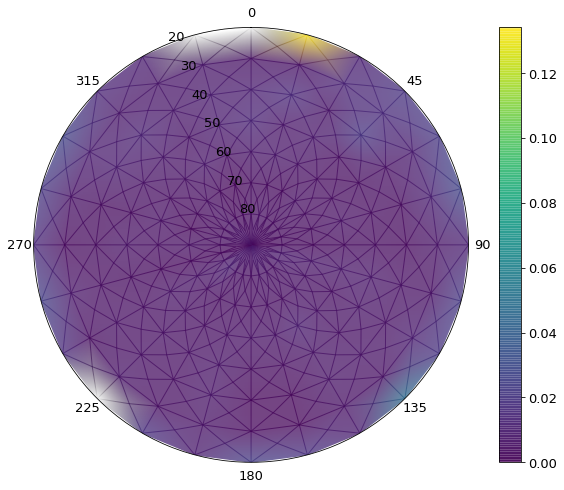

In [408]:
FreqLo = 1310
FreqHi = 1490
ChanIndx = np.where((MyMeanFreqProb.frequency.frequency >= FreqLo*1.e6) & 
                    (MyMeanFreqProb.frequency.frequency <= FreqHi*1.e6))[0]

if len(ChanIndx) != 0:


    SpecMaster = MyMaster.sum(dim = ['time','baseline'])
    SpecMaster = SpecMaster[ChanIndx].sum(dim = ['frequency'])

    SpecCounter = MyCounter.sum(dim = ['time','baseline'])
    SpecCounter = SpecCounter.sum(dim = ['frequency'])

    SpecProb = SpecMaster.astype(float)/SpecCounter.astype(float)
    SpecProb = SpecProb.persist()

    Mydata = SpecProb
    
    MyPLot(AzProb,ElProb,Mydata)
else:
    print("Something went wrong in Frequency selection")